### **Import libraries**

In [76]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils import Quaternion

### **Extract the data from ground truth odometry**

In [77]:
dataset = 1 # 00 to 10

# reference for string formatting: https://stackoverflow.com/questions/473282/how-can-i-pad-an-integer-with-zeros-on-the-left
filepath = 'dataset/kitti_odom/gt_poses/{:02d}.txt'.format(dataset)
poses_df = pd.read_csv(filepath, delimiter=' ', header=None)

print('Length of the dataset:', poses_df.shape)
poses_df.head()

Length of the dataset: (1101, 12)


,0,1,2,3,4,5,6,7,8,9,10,11
0,1.000000,9.043683e-12,2.326809e-11,1.110223e-16,9.043683e-12,1.000000,2.392370e-10,2.220446e-16,2.326810e-11,2.392370e-10,1.000000,-2.220446e-16
1,0.999050,-1.649780e-03,4.355194e-02,5.154656e-02,1.760423e-03,0.999995,-2.502237e-03,-2.424883e-02,-4.354760e-02,2.576529e-03,0.999048,1.000725e+00
2,0.996050,-5.367949e-03,8.863831e-02,1.464632e-01,6.010224e-03,0.999958,-6.980718e-03,-5.051622e-02,-8.859707e-02,7.485875e-03,0.996039,1.995659e+00
3,0.990927,-5.886878e-03,1.342721e-01,2.879204e-01,7.448178e-03,0.999910,-1.112852e-02,-7.903059e-02,-1.341946e-01,1.202763e-02,0.990882,2.986691e+00
4,0.983622,-3.565066e-03,1.802072e-01,4.657503e-01,6.172884e-03,0.999884,-1.391250e-02,-1.102928e-01,-1.801368e-01,1.479704e-02,0.983530,3.963845e+00


In [78]:
poses_camera = np.array(poses_df)
poses_camera = poses_camera.reshape((poses_df.shape[0], 3, 4))

# print example numpy array
print(poses_camera[0])

[[ 1.000000e+00  9.043683e-12  2.326809e-11  1.110223e-16]
 [ 9.043683e-12  1.000000e+00  2.392370e-10  2.220446e-16]
 [ 2.326810e-11  2.392370e-10  9.999999e-01 -2.220446e-16]]


### **Convert camera coordinates to world coordinates**

In [79]:
poses_world = np.zeros((poses_df.shape[0], 3))  # data_len, x, y, yaw
euler_angles_cam = np.zeros((poses_df.shape[0], 3))

poses_world[:, 0] = poses_camera[:, 2, 3]      # x-coordinate (Zc = Xw)
poses_world[:, 1] = -1 * poses_camera[:, 0, 3] # y-coordinate (-Xc = Yw)

# get yaw angle from rotation matrix
for i in range(poses_df.shape[0]):
    q = Quaternion()
    q.from_rotm(poses_camera[i, :3, :3])
    euler_angles_cam[i] = q.euler_angles()

poses_world[:, 2] = -1 * euler_angles_cam[:, 1] # yaw angle (-camera pitch = world yaw)

print(poses_world)

[[-2.22044600e-16 -1.11022300e-16  5.00000012e-18]
 [ 1.00072500e+00 -5.15465600e-02 -4.35613802e-02]
 [ 1.99565900e+00 -1.46463200e-01 -8.87133913e-02]
 ...
 [-1.04814500e+03 -1.67938100e+03 -5.47417241e-01]
 [-1.04673900e+03 -1.68025900e+03 -5.49499600e-01]
 [-1.04529100e+03 -1.68116700e+03 -5.51464985e-01]]


### **Plot the odometry data**

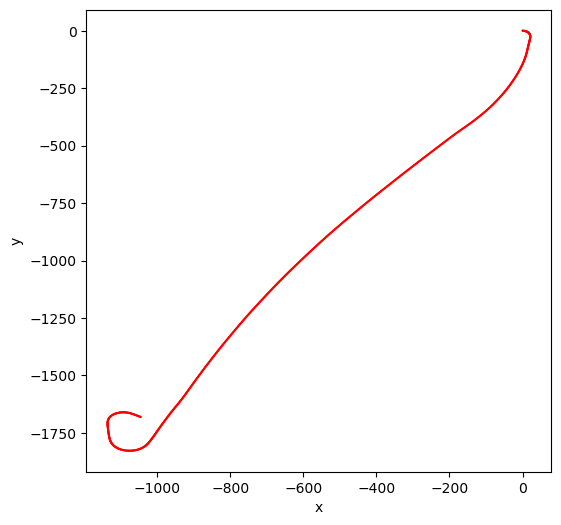

In [80]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
length = 0.1

# Plot arrows
for i, (x, y, yaw) in enumerate(poses_world):
    dx = length * np.cos(yaw)  # Calculate arrow delta x
    dy = length * np.sin(yaw)  # Calculate arrow delta y
    ax.quiver(x, y, dx, dy, angles='xy', scale_units='xy', scale=0.1, width=0.005, headwidth=5, color='red')

ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

### **Export the data**

In [81]:
savefile = 'dataset/' + 'poses_world_{:02d}.npz'.format(dataset)

# save poses_world to a .npz file
np.savez(savefile, poses_world=poses_world)